In [146]:
import itertools
import csv
import torch

import networkx as nx
import numpy as np
import torch.nn as nn

from collections import defaultdict
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree
from sklearn.cluster import AgglomerativeClustering

from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt

In [101]:
graph_data = []
with open("../data/pairwise-categorization/results/google_gemma-2-9b-it.csv", "r") as f:
    rows = csv.DictReader(f)
    for row in rows:
        concept1, concept2 = row['concept1'], row['concept2']
        if concept1 != concept2:
            graph_data.append((concept2, concept1, float(row['no']) - float(row['yes'])))

In [102]:
# load graph data into a square matrix

concepts = defaultdict(lambda : len(concepts))

matrix_data = defaultdict(float)

for row in graph_data:
    idx1 = concepts[row[0]]
    idx2 = concepts[row[1]]

    matrix_data[(idx1, idx1)] = 0.0
    matrix_data[(idx2, idx2)] = 0.0
    matrix_data[(idx1, idx2)] = row[2]


In [106]:
matrix = torch.zeros(len(concepts), len(concepts))

# take average of c1, c2 and c2, c1
for c1, c2 in itertools.product(list(range(len(concepts))), list(range(len(concepts)))):
    if c1 == c2:
        matrix[c1, c2] = 0.0
    else:
        matrix[c1, c2] = (matrix_data[(c1, c2)] + matrix_data[(c2, c1)]) / 2

# for (c1, c2), val in matrix_data.items():
#     matrix[c1, c2] = val

In [115]:
matrix

tensor([[0.0000, 8.8438, 7.0312,  ..., 9.5312, 9.0938, 9.7500],
        [8.8438, 0.0000, 7.6875,  ..., 9.5000, 9.2188, 9.7500],
        [7.0312, 7.6875, 0.0000,  ..., 9.5000, 8.5312, 9.5312],
        ...,
        [9.5312, 9.5000, 9.5000,  ..., 0.0000, 9.1875, 9.0000],
        [9.0938, 9.2188, 8.5312,  ..., 9.1875, 0.0000, 8.9062],
        [9.7500, 9.7500, 9.5312,  ..., 9.0000, 8.9062, 0.0000]])

In [117]:
matrix.min()

tensor(-8.9375)

In [129]:
# matrix - matrix.min(1).values
pairwise = (matrix - matrix.min())/(matrix.max() - matrix.min())

pairwise.fill_diagonal_(0.0)

tensor([[0.0000, 0.9133, 0.8202,  ..., 0.9486, 0.9262, 0.9599],
        [0.9133, 0.0000, 0.8539,  ..., 0.9470, 0.9326, 0.9599],
        [0.8202, 0.8539, 0.0000,  ..., 0.9470, 0.8973, 0.9486],
        ...,
        [0.9486, 0.9470, 0.9470,  ..., 0.0000, 0.9310, 0.9213],
        [0.9262, 0.9326, 0.8973,  ..., 0.9310, 0.0000, 0.9165],
        [0.9599, 0.9599, 0.9486,  ..., 0.9213, 0.9165, 0.0000]])

In [130]:
pairwise

tensor([[0.0000, 0.9133, 0.8202,  ..., 0.9486, 0.9262, 0.9599],
        [0.9133, 0.0000, 0.8539,  ..., 0.9470, 0.9326, 0.9599],
        [0.8202, 0.8539, 0.0000,  ..., 0.9470, 0.8973, 0.9486],
        ...,
        [0.9486, 0.9470, 0.9470,  ..., 0.0000, 0.9310, 0.9213],
        [0.9262, 0.9326, 0.8973,  ..., 0.9310, 0.0000, 0.9165],
        [0.9599, 0.9599, 0.9486,  ..., 0.9213, 0.9165, 0.0000]])

In [135]:
clusters = linkage(squareform(pairwise), method='average')

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [105.0, 105.0, 115.0, 115.0],
  [95.0, 95.0, 110.0, 110.0],
  [72.5, 72.5, 102.5, 102.5],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [165.0, 165.0, 182.5, 182.5],
  [155.0, 155.0, 173.75, 173.75],
  [145.0, 145.0, 164.375, 164.375],
  [135.0, 135.0, 154.6875, 154.6875],
  [125.0, 125.0, 144.84375, 144.84375],
  [87.5, 87.5, 134.921875, 134.921875],
  [55.0, 55.0, 111.2109375, 111.2109375],
  [225.0, 225.0, 235.0, 235.0],
  [215.0, 215.0, 230.0, 230.0],
  [205.0, 205.0, 222.5, 222.5],
  [245.0, 245.0, 255.0, 255.0],
  [265.0, 265.0, 275.0, 275.0],
  [295.0, 295.0, 305.0, 305.0],
  [285.0, 285.0, 300.0, 300.0],
  [270.0, 270.0, 292.5, 292.5],
  [250.0, 250.0, 281.25, 281.25],
  [315.0, 315.0, 325.0, 325.0],
  [335.0, 335.0, 345.0, 345.0],
  [320.0, 320.0, 340.0, 340.0],
  [265.625, 265.625, 330.0, 330.0],
  [213.75, 213.75, 297.8125, 297.8125],


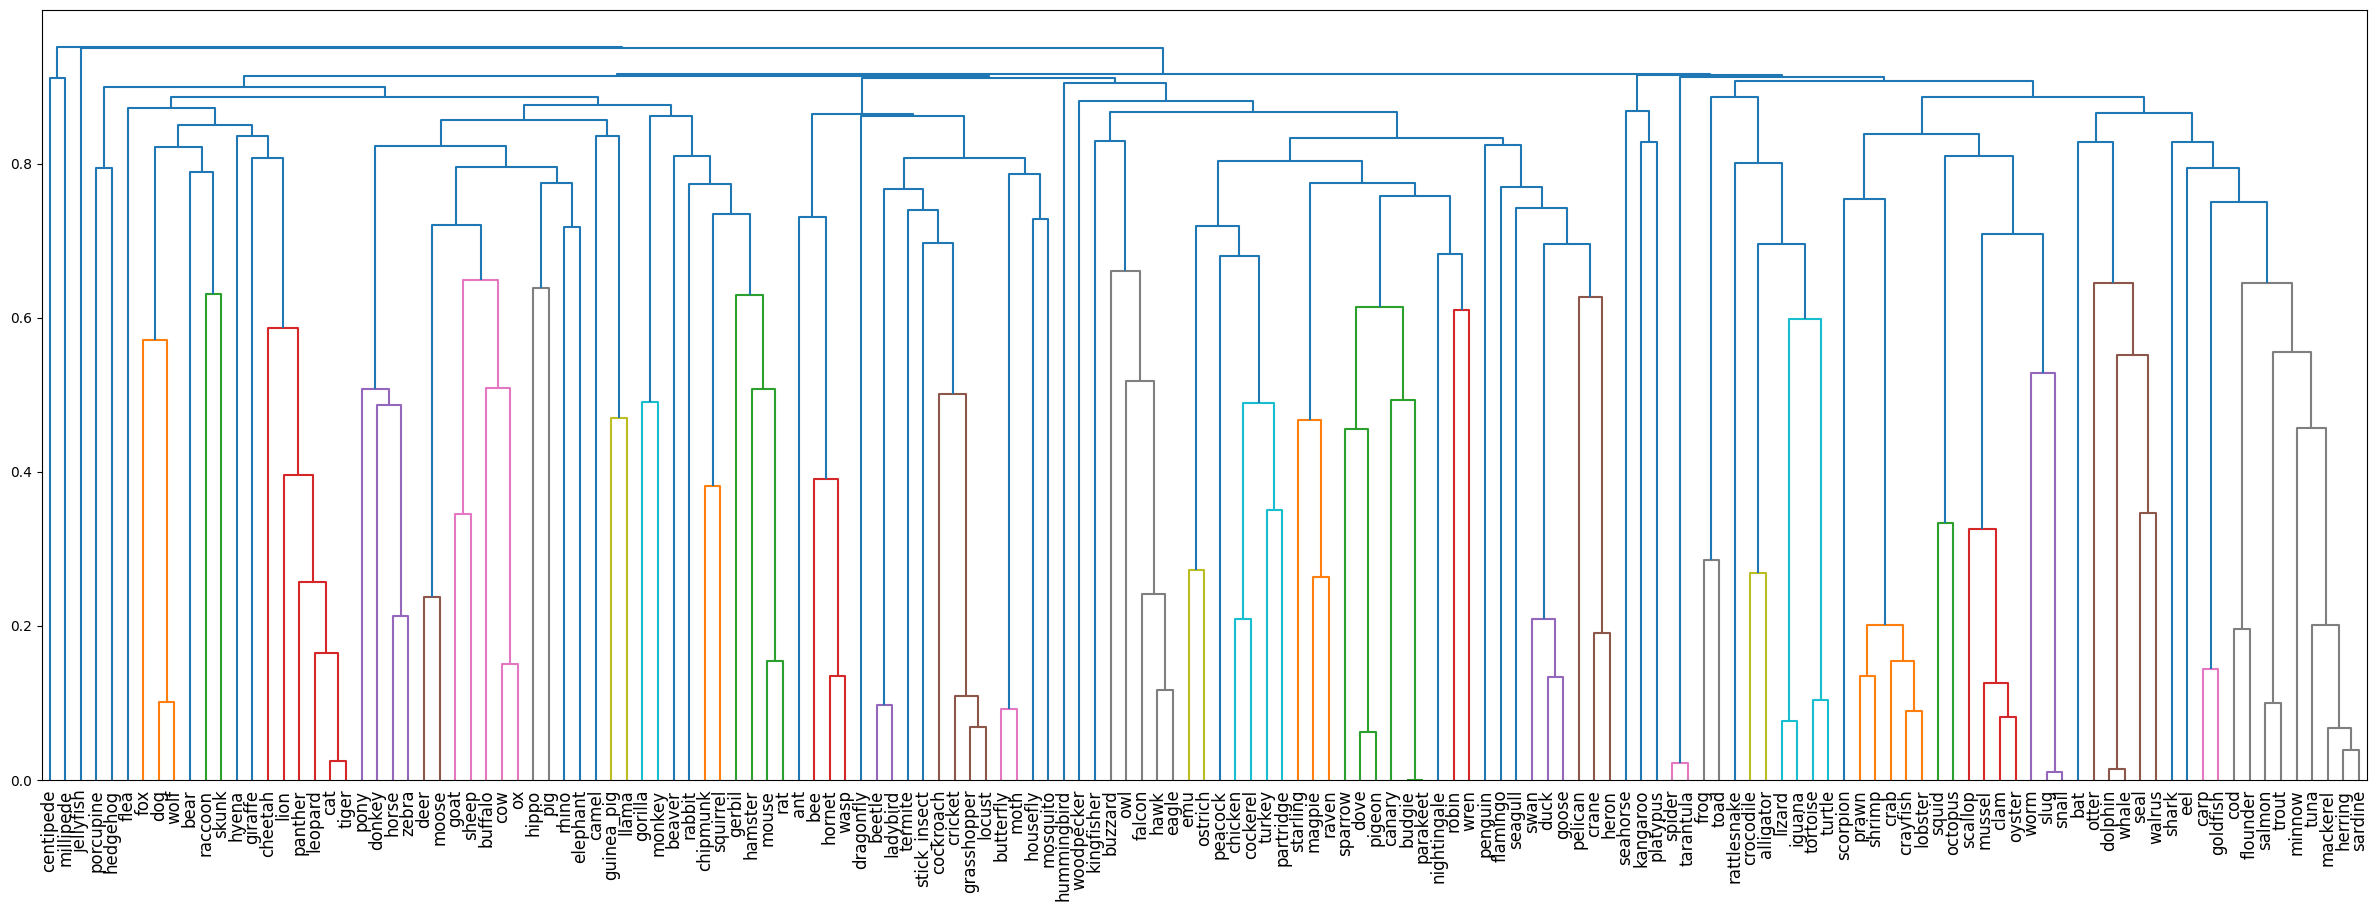

In [144]:
c2i = {i : c for c, i in concepts.items()}

# c2i
plt.figure(figsize=(30, 10))
dendrogram(clusters, labels=[c2i[i] for i in range(len(concepts))], leaf_font_size=12)

# plt.savefig('/plt.png', format='png', bbox_inches='tight')
# plt.savefig('~/plt.jpg', format='jpg', bbox_inches='tight')

In [155]:
hierarchy_classes = to_tree(clusters)

In [156]:
import graphviz


def render_tree(tree, labels):
    dot = graphviz.Digraph('cluster_heirarchy')
    render_tree_recursive(tree, dot, labels)
    return dot


def render_tree_recursive(node, dot, labels, parent=None):
    label = None
    if node.count == 1 and node.id < len(labels):
        label = labels[node.id]
    dot.node(f"c{node.id}", label)
    if parent is not None:
        dot.edge(f"c{parent.id}", f"c{node.id}")
    if node.left is not None:
        render_tree_recursive(node.left, dot, labels, node)
    if node.right is not None:
        render_tree_recursive(node.right, dot, labels, node)

In [157]:
graph = render_tree(hierarchy_classes, labels=[c2i[i] for i in range(len(concepts))])


In [160]:
graph.render('../plots/behaviorally-induced-taxonomy-first-pass-animals', format='pdf')

'../plots/behaviorally-induced-taxonomy-first-pass-animals.pdf'